# MetaFam Knowledge Graph Exploration - Task 1

**Objective**: Execute comprehensive dataset exploration for the MetaFam family knowledge graph.

This notebook implements:
1. **Data Loading** - Graph construction from triples
2. **Basic EDA** - Relationship distribution analysis
3. **Network Metrics** - Global and node-level statistics
4. **Gender Inference** - Rule-based classification
5. **Gephi Export** - Visualization-ready output

---

## Theoretical Foundation

### Knowledge Graph Representation
A Knowledge Graph (KG) stores information as triples: `(Head, Relation, Tail)`
- **Head/Tail**: Entity nodes (people in our family graph)
- **Relation**: Edge type defining the relationship

Example: `(Alice, motherOf, Bob)` means Alice is the mother of Bob.

### Why Graph Analysis for Genealogy?
- **Centrality metrics** identify important individuals (patriarchs, matriarchs)
- **Connected components** reveal separate family lineages
- **Generational depth** maps the family tree hierarchy
- **Gender inference** demonstrates rule-based reasoning on KGs

## 1. Setup & Imports

In [1]:
# Standard library imports
import sys
import os
from pathlib import Path
from collections import Counter

# Data science imports
import numpy as np
import pandas as pd

# Graph analysis
import networkx as nx

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
%matplotlib inline

# Add src to path for custom module imports
src_path = Path('../src').resolve()
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# Import custom modules
from data_loader import load_graph, get_relationship_counts, get_unique_relations
from exploration import (
    calculate_global_metrics, print_global_metrics,
    calculate_node_features, infer_gender, get_gender_summary,
    plot_relationship_distribution, plot_degree_distribution,
    plot_generation_distribution, export_to_gephi
)

print("All imports successful!")
print(f"NetworkX version: {nx.__version__}")

All imports successful!
NetworkX version: 3.6.1


## 2. Data Loading & Graph Construction

Load the MetaFam dataset and construct both directed and undirected graph representations.

**Theoretical Note:**
- **Directed Graph**: Preserves semantic direction (e.g., `fatherOf` implies parent→child)
- **Undirected Graph**: Treats relationships as bidirectional (useful for community detection)

In [2]:
# Define data path
DATA_PATH = Path('../data/raw/train.txt').resolve()
print(f"Loading data from: {DATA_PATH}")
print(f"File exists: {DATA_PATH.exists()}")

# Load graphs
G_directed, G_undirected = load_graph(str(DATA_PATH))

Loading data from: D:\college\Precog\Precog_task_graphs\data\raw\train.txt
File exists: True
Loading graph from: D:\college\Precog\Precog_task_graphs\data\raw\train.txt
--------------------------------------------------

GRAPH CONSTRUCTION SANITY CHECK

DATA STATISTICS:
   - Total triples processed: 13,821
   - Unique relationship types: 28

DIRECTED GRAPH (G_directed):
   - Nodes: 1,316
   - Edges: 13,821
   - Graph type: DiGraph

UNDIRECTED GRAPH (G_undirected):
   - Nodes: 1,316
   - Edges: 7,480
   - Graph type: Graph


## 3. Basic Exploratory Data Analysis

### 3.1 Relationship Type Distribution

Understanding what types of relationships exist in the knowledge graph and their frequencies.

In [3]:
# Get relationship counts
relation_counts = get_relationship_counts(G_directed)

# Display as DataFrame for clarity
relation_df = pd.DataFrame([
    {'Relationship': rel, 'Count': count}
    for rel, count in sorted(relation_counts.items(), key=lambda x: -x[1])
])

print(f"\nRELATIONSHIP TYPE STATISTICS:")
print(f"   • Total unique relationship types: {len(relation_counts)}")
print(f"   • Total edges (relations): {sum(relation_counts.values()):,}")
print(f"\nRelationships by frequency:")
display(relation_df)


RELATIONSHIP TYPE STATISTICS:
   • Total unique relationship types: 28
   • Total edges (relations): 13,821

Relationships by frequency:


,Relationship,Count
0,grandsonOf,814
1,grandmotherOf,813
2,grandfatherOf,813
3,granddaughterOf,812
4,motherOf,733
5,fatherOf,733
6,sisterOf,636
7,daughterOf,628
8,greatGrandsonOf,624
9,greatGrandmotherOf,617


Plot saved to: ../outputs/plots/relationship_distribution.png


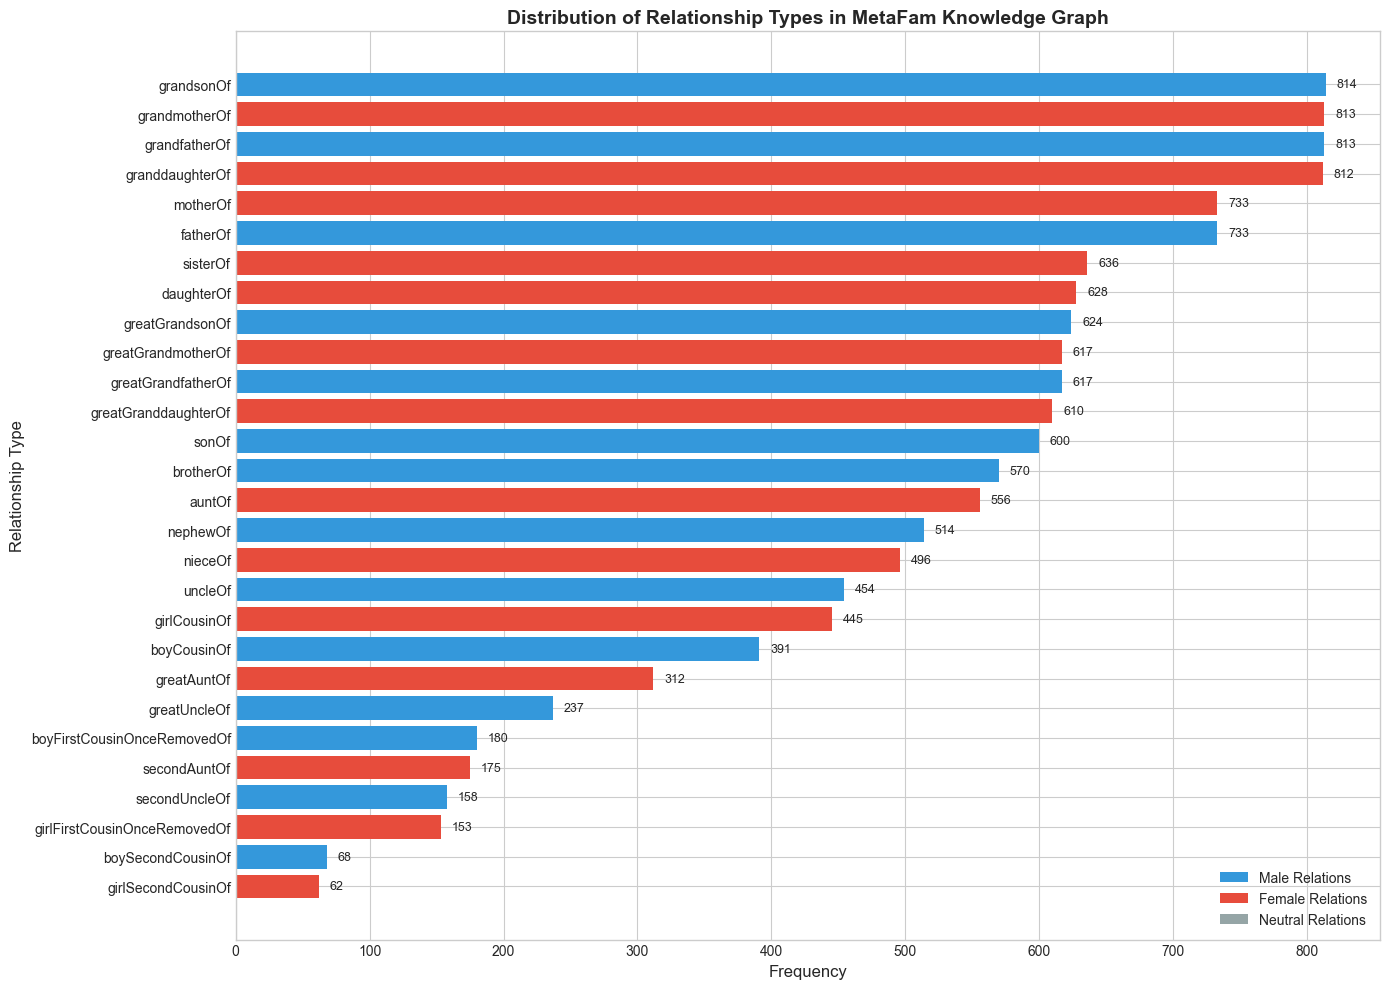

In [4]:
# Visualize relationship distribution
plot_relationship_distribution(
    relation_counts,
    save_path='../outputs/plots/relationship_distribution.png',
    figsize=(14, 10)
)

### 3.2 Relationship Analysis Insights

Let's categorize relationships by type for deeper understanding.

In [5]:
# Categorize relationships
all_relations = get_unique_relations(G_directed)

# Define categories
parent_child = [r for r in all_relations if any(x in r.lower() for x in ['father', 'mother', 'son', 'daughter', 'parent', 'child'])]
sibling = [r for r in all_relations if any(x in r.lower() for x in ['brother', 'sister', 'sibling'])]
grandparent = [r for r in all_relations if 'grand' in r.lower()]
aunt_uncle = [r for r in all_relations if any(x in r.lower() for x in ['aunt', 'uncle', 'niece', 'nephew'])]
spouse = [r for r in all_relations if any(x in r.lower() for x in ['husband', 'wife', 'spouse'])]
cousin = [r for r in all_relations if 'cousin' in r.lower()]

print("RELATIONSHIP CATEGORIZATION:")
print(f"\n   Parent-Child relations ({len(parent_child)}): {sorted(parent_child)}")
print(f"\n   Sibling relations ({len(sibling)}): {sorted(sibling)}")
print(f"\n   Grandparent relations ({len(grandparent)}): {sorted(grandparent)}")
print(f"\n   Aunt/Uncle relations ({len(aunt_uncle)}): {sorted(aunt_uncle)}")
print(f"\n   Spouse relations ({len(spouse)}): {sorted(spouse)}")
print(f"\n   Cousin relations ({len(cousin)}): {sorted(cousin)}")

RELATIONSHIP CATEGORIZATION:

   Parent-Child relations (12): ['daughterOf', 'fatherOf', 'granddaughterOf', 'grandfatherOf', 'grandmotherOf', 'grandsonOf', 'greatGranddaughterOf', 'greatGrandfatherOf', 'greatGrandmotherOf', 'greatGrandsonOf', 'motherOf', 'sonOf']

   Sibling relations (2): ['brotherOf', 'sisterOf']

   Grandparent relations (8): ['granddaughterOf', 'grandfatherOf', 'grandmotherOf', 'grandsonOf', 'greatGranddaughterOf', 'greatGrandfatherOf', 'greatGrandmotherOf', 'greatGrandsonOf']

   Aunt/Uncle relations (8): ['auntOf', 'greatAuntOf', 'greatUncleOf', 'nephewOf', 'nieceOf', 'secondAuntOf', 'secondUncleOf', 'uncleOf']

   Spouse relations (0): []

   Cousin relations (6): ['boyCousinOf', 'boyFirstCousinOnceRemovedOf', 'boySecondCousinOf', 'girlCousinOf', 'girlFirstCousinOnceRemovedOf', 'girlSecondCousinOf']


## 4. Advanced Network Characteristics

### 4.1 Global Metrics (Macroscopic Analysis)

These metrics describe the overall structure of the family knowledge graph:

| Metric | Description | Relevance to Family Graphs |
|--------|-------------|---------------------------|
| **Density** | Ratio of actual to possible edges | Low density expected (sparse family connections) |
| **WCC** | Weakly Connected Components | Each WCC = separate family tree |
| **Clustering** | Transitivity measure | Shared family relationships |

In [6]:
# Calculate global metrics
global_metrics = calculate_global_metrics(G_directed)

# Pretty print
print_global_metrics(global_metrics)


GLOBAL NETWORK METRICS REPORT

BASIC STATISTICS:
   - Total Nodes (People):     1,316
   - Total Edges (Relations):  13,821
   - Average Degree:           10.50

STRUCTURAL METRICS:
   - Graph Density:            0.007987
     Interpretation: Very sparse (typical for social/family networks)

   - Average Clustering Coef:  0.7346
     Measures transitivity of family relationships

CONNECTIVITY ANALYSIS:
   - Weakly Connected Components: 50
   - Largest Component Size:      27 nodes
   - Smallest Component Size:     26 nodes
   - Average Component Size:      26.3 nodes

   Component Size Distribution (top 10):
      1. 27 nodes
      2. 27 nodes
      3. 27 nodes
      4. 27 nodes
      5. 27 nodes
      6. 27 nodes
      7. 27 nodes
      8. 27 nodes
      9. 27 nodes
      10. 27 nodes



### 4.2 Node Features (Microscopic Analysis)

Calculate and store node-level features:

| Feature | Formula | Interpretation |
|---------|---------|---------------|
| **In-Degree** | Count of incoming edges | Descendants have high in-degree |
| **Out-Degree** | Count of outgoing edges | Ancestors have high out-degree |
| **PageRank** | $PR(v) = \frac{1-d}{N} + d \sum_{u \to v} \frac{PR(u)}{out(u)}$ | Important ancestors (many point to them) |
| **Generation** | BFS distance from root | Family tree depth |

**Note:** Betweenness centrality is computed for analysis but NOT stored as a node attribute to reduce export size.

In [7]:
# Calculate node features
G_directed = calculate_node_features(G_directed, verbose=True)


CALCULATING NODE FEATURES

Computing degree metrics...
   - In-Degree:    min=0, max=23, mean=10.50
   - Out-Degree:   min=1, max=22, mean=10.50

Computing centrality metrics...
   - PageRank: max=0.001857, mean=0.000760
   - Betweenness: max=0.0001, mean=0.0000 (analysis only)

   Top 5 nodes by PageRank (Important Ancestors):
      - gabriel241: 0.001857
      - lea1165: 0.001841
      - raphael29: 0.001809
      - christian712: 0.001682
      - tobias713: 0.001682

   Top 5 nodes by Betweenness (Family Bridges):
      - lea1165: 0.0001
      - valentin638: 0.0001
      - gabriel241: 0.0001
      - nora536: 0.0001
      - stefan1192: 0.0001

Computing generational depth...
   - Parental subgraph: 4326 parent->descendant edges
   - Generation range: 0 to 3
   - Mean generation: 0.78

   Generation Distribution:
      Gen 0: 519 people
      Gen 1: 572 people
      Gen 2: 216 people
      Gen 3: 9 people

Node features successfully added to graph.


Plot saved to: ../outputs/plots/degree_distribution.png


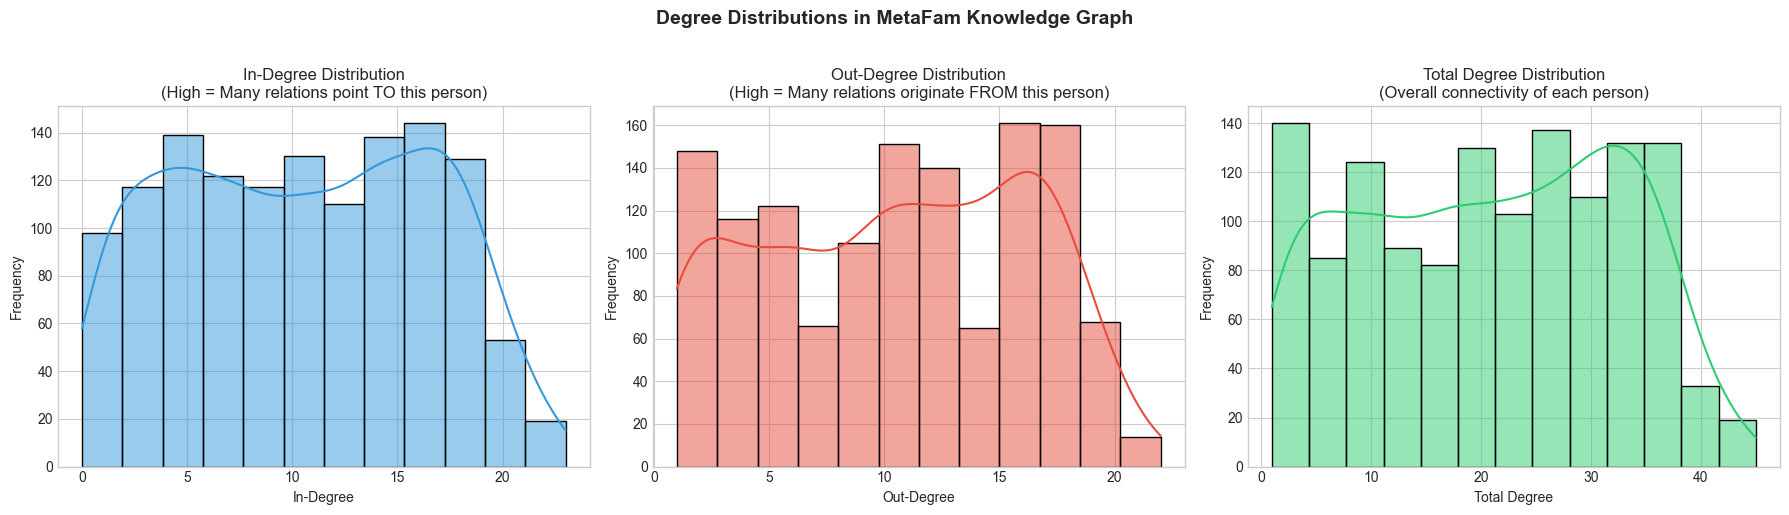

In [8]:
# Visualize degree distributions
plot_degree_distribution(
    G_directed,
    save_path='../outputs/plots/degree_distribution.png'
)

Plot saved to: ../outputs/plots/generation_distribution.png


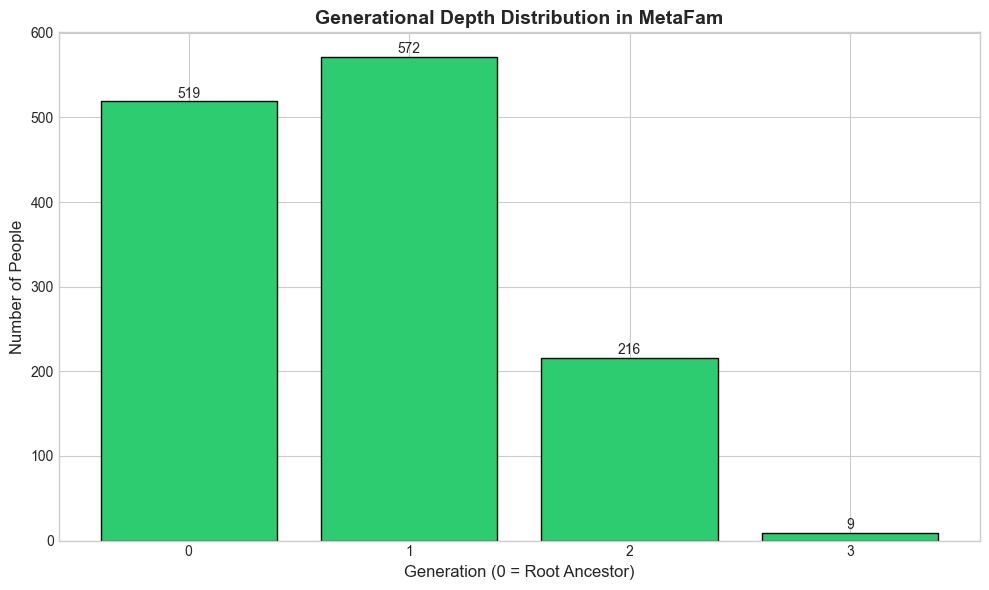

In [9]:
# Visualize generational distribution
plot_generation_distribution(
    G_directed,
    save_path='../outputs/plots/generation_distribution.png'
)

### 4.3 Key Individuals Analysis

Identify important nodes based on PageRank and degree metrics.

In [10]:
# Create DataFrame of node features for analysis
node_data = []
for node in G_directed.nodes():
    attrs = G_directed.nodes[node]
    node_data.append({
        'Node': node,
        'In_Degree': attrs.get('in_degree', 0),
        'Out_Degree': attrs.get('out_degree', 0),
        'PageRank': attrs.get('pagerank', 0),
        'Generation': attrs.get('generation', -1)
    })

nodes_df = pd.DataFrame(node_data)

print("TOP 10 BY PAGERANK (Important Ancestors):")
print("   PageRank measures node importance based on incoming link quality.")
print("   High PageRank = important person many descendants 'point to'.\n")
display(nodes_df.nlargest(10, 'PageRank')[['Node', 'PageRank', 'Generation']])

print("\nTOP 10 BY OUT-DEGREE (Likely Ancestors):")
print("   High out-degree indicates many outgoing relations (parentOf, etc.)\n")
display(nodes_df.nlargest(10, 'Out_Degree')[['Node', 'Out_Degree', 'Generation']])

print("\nTOP 10 BY IN-DEGREE (Highly Referenced Individuals):")
print("   High in-degree indicates many relations point TO this person\n")
display(nodes_df.nlargest(10, 'In_Degree')[['Node', 'In_Degree', 'Generation']])

TOP 10 BY PAGERANK (Important Ancestors):
   PageRank measures node importance based on incoming link quality.
   High PageRank = important person many descendants 'point to'.



,Node,PageRank,Generation
241,gabriel241,0.001857,2
1168,lea1165,0.001841,2
34,raphael29,0.001809,2
712,christian712,0.001682,2
713,tobias713,0.001682,2
426,emilia428,0.001676,2
166,simon172,0.001644,2
270,victoria279,0.001631,2
948,benjamin952,0.001603,1
1140,helena1135,0.001571,2



TOP 10 BY OUT-DEGREE (Likely Ancestors):
   High out-degree indicates many outgoing relations (parentOf, etc.)



,Node,Out_Degree,Generation
137,oskar133,22,2
138,larissa136,22,2
139,fabian140,22,2
154,laura143,22,2
1032,dominik1036,22,2
1034,olivia1043,22,2
1035,magdalena1044,22,2
1036,oliver1045,22,2
1040,lisa1035,22,2
1,selina10,21,1



TOP 10 BY IN-DEGREE (Highly Referenced Individuals):
   High in-degree indicates many relations point TO this person



,Node,In_Degree,Generation
1032,dominik1036,23,2
1035,magdalena1044,23,2
1036,oliver1045,23,2
1040,lisa1035,23,2
19,lisa5,22,1
20,elias6,22,1
136,gabriel146,22,2
137,oskar133,22,2
138,larissa136,22,2
139,fabian140,22,2


## 5. Gender Classification

### Rule-Based Gender Inference

We infer gender based on the relationship type where a node appears as the **HEAD** (source):

**Male-indicating relations:**
- `fatherOf`, `brotherOf`, `sonOf`, `uncleOf`, `husbandOf`, `grandfatherOf`, etc.

**Female-indicating relations:**
- `motherOf`, `sisterOf`, `daughterOf`, `auntOf`, `wifeOf`, `grandmotherOf`, etc.

### Conflict Handling
If a node appears as HEAD of both male AND female relations → marked as `Unmapped` (data inconsistency)

In [11]:
# Infer gender
G_directed, gender_summary = infer_gender(G_directed, verbose=True)


GENDER INFERENCE

GENDER CLASSIFICATION SUMMARY:
   - Male:     646 nodes
   - Female:   670 nodes
   - Unknown:  0 nodes
   - Unmapped: 0 nodes (conflicts)



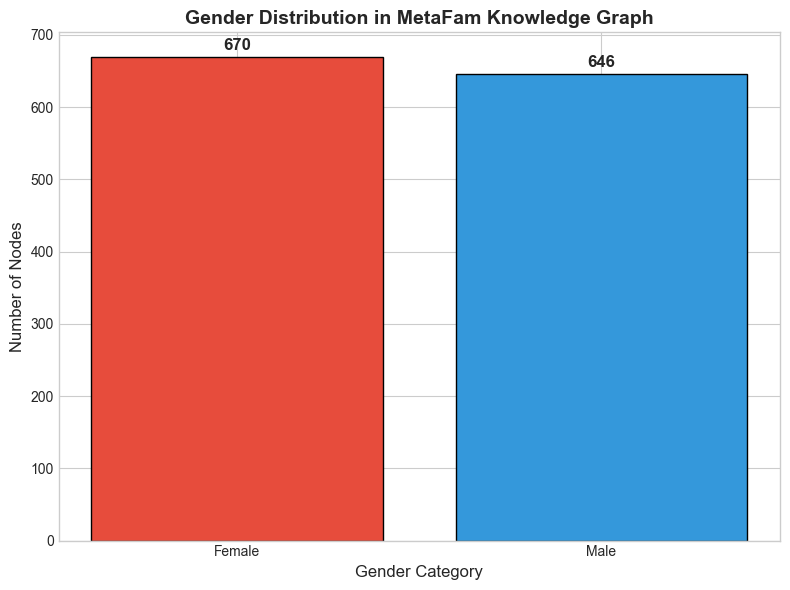


Gender Distribution:
   Female: 670 (50.9%)
   Male: 646 (49.1%)


In [12]:
# Visualize gender distribution
gender_counts = get_gender_summary(G_directed)

fig, ax = plt.subplots(figsize=(8, 6))

colors = {'Male': '#3498db', 'Female': '#e74c3c', 'Unknown': '#95a5a6', 'Unmapped': '#f39c12'}
labels = list(gender_counts.keys())
sizes = list(gender_counts.values())
color_list = [colors.get(l, '#333') for l in labels]

bars = ax.bar(labels, sizes, color=color_list, edgecolor='black')

# Add count labels
for bar, count in zip(bars, sizes):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
            f'{count:,}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_xlabel('Gender Category', fontsize=12)
ax.set_ylabel('Number of Nodes', fontsize=12)
ax.set_title('Gender Distribution in MetaFam Knowledge Graph', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/plots/gender_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nGender Distribution:")
total = sum(gender_counts.values())
for gender, count in gender_counts.items():
    print(f"   {gender}: {count:,} ({count/total*100:.1f}%)")

## 6. Data Quality & Consistency Check

In [13]:
# Verify all node attributes are present
sample_node = list(G_directed.nodes())[0]
print(f"Sample node: {sample_node}")
print(f"Attributes: {dict(G_directed.nodes[sample_node])}")

# Check for missing values (updated for Task 1 refined attributes)
required_attrs = ['gender', 'generation', 'in_degree', 'out_degree', 'pagerank']
missing_report = {}

for attr in required_attrs:
    values = nx.get_node_attributes(G_directed, attr)
    missing = G_directed.number_of_nodes() - len(values)
    missing_report[attr] = missing

print(f"\nATTRIBUTE COMPLETENESS CHECK:")
for attr, missing in missing_report.items():
    status = "[OK]" if missing == 0 else "[MISSING]"
    print(f"   {status} {attr}: {missing} missing values")

Sample node: olivia0
Attributes: {'in_degree': 19, 'out_degree': 20, 'pagerank': 0.0009521976444432567, 'generation': 2, 'gender': 'Female'}

ATTRIBUTE COMPLETENESS CHECK:
   [OK] gender: 0 missing values
   [OK] generation: 0 missing values
   [OK] in_degree: 0 missing values
   [OK] out_degree: 0 missing values
   [OK] pagerank: 0 missing values


## 7. Gephi Export

Export the enriched graph to GEXF format for visualization in Gephi.

In [14]:
# Export to Gephi (Task 1 refined output)
export_path = '../outputs/gephi/metafam_task1_refined.gexf'
export_to_gephi(G_directed, export_path)


GEPHI EXPORT
All required node attributes present.

File exported: ../outputs/gephi/metafam_task1_refined.gexf
   - Nodes: 1,316
   - Edges: 13,821
   - Node attributes: ['gender', 'generation', 'in_degree', 'out_degree', 'pagerank']
   - File size: 2.63 MB

GEPHI TIPS:
   1. Import this file in Gephi (File > Open)
   2. Use 'gender' attribute for node coloring
   3. Use 'generation' for vertical layout
   4. Use 'pagerank' for node sizing (important ancestors)
   5. Run ForceAtlas2 layout for network visualization



## 8. Summary Statistics

In [15]:
# Final summary
print("\n" + "="*70)
print("METAFAM KNOWLEDGE GRAPH - EXPLORATION SUMMARY (TASK 1 REFINED)")
print("="*70)

print(f"\nGRAPH STATISTICS:")
print(f"   - Total People (Nodes): {G_directed.number_of_nodes():,}")
print(f"   - Total Relations (Edges): {G_directed.number_of_edges():,}")
print(f"   - Unique Relationship Types: {len(relation_counts)}")
print(f"   - Graph Density: {global_metrics['density']:.6f}")
print(f"   - Connected Components: {global_metrics['num_weakly_connected_components']}")

print(f"\nGENDER DISTRIBUTION:")
for gender, count in get_gender_summary(G_directed).items():
    print(f"   - {gender}: {count:,}")

generations = nx.get_node_attributes(G_directed, 'generation')
valid_gens = [g for g in generations.values() if g >= 0]
print(f"\nGENERATIONAL DEPTH:")
print(f"   - Generation range: {min(valid_gens)} to {max(valid_gens)}")
print(f"   - Number of generations: {max(valid_gens) + 1}")

# PageRank statistics
pagerank_vals = nx.get_node_attributes(G_directed, 'pagerank')
pr_values = list(pagerank_vals.values())
print(f"\nPAGERANK STATISTICS:")
print(f"   - PageRank: min={min(pr_values):.6f}, max={max(pr_values):.6f}, mean={np.mean(pr_values):.6f}")

print(f"\nNODE ATTRIBUTES STORED:")
print(f"   - in_degree, out_degree, pagerank, generation, gender")
print(f"   - Note: Betweenness computed for analysis but NOT stored as attribute")

print(f"\nOUTPUT FILES:")
print(f"   - Gephi export: outputs/gephi/metafam_task1_refined.gexf")
print(f"   - Plots saved to: outputs/plots/")

print("\n" + "="*70)
print("Task 1: Dataset Exploration (REFINED) COMPLETE")
print("="*70)


METAFAM KNOWLEDGE GRAPH - EXPLORATION SUMMARY (TASK 1 REFINED)

GRAPH STATISTICS:
   - Total People (Nodes): 1,316
   - Total Relations (Edges): 13,821
   - Unique Relationship Types: 28
   - Graph Density: 0.007987
   - Connected Components: 50

GENDER DISTRIBUTION:
   - Female: 670
   - Male: 646

GENERATIONAL DEPTH:
   - Generation range: 0 to 3
   - Number of generations: 4

PAGERANK STATISTICS:
   - PageRank: min=0.000114, max=0.001857, mean=0.000760

NODE ATTRIBUTES STORED:
   - in_degree, out_degree, pagerank, generation, gender
   - Note: Betweenness computed for analysis but NOT stored as attribute

OUTPUT FILES:
   - Gephi export: outputs/gephi/metafam_task1_refined.gexf
   - Plots saved to: outputs/plots/

Task 1: Dataset Exploration (REFINED) COMPLETE


---

## Appendix: Key Insights & Theoretical Notes

### A. Why These Metrics Matter for Family Graphs

1. **PageRank Centrality** identifies important ancestors:
   - Measures node importance based on incoming link quality
   - High PageRank = important person many descendants "point to"
   - Considers not just quantity but quality of connections
   - Useful for identifying historically significant individuals

2. **In-Degree vs Out-Degree Asymmetry**:
   - In directed family KGs with relations like `fatherOf`, `motherOf`:
   - **High Out-Degree** -> Ancestors (they are `parentOf` many)
   - **High In-Degree** -> Descendants (many `childOf` point to them)

3. **Generational Depth Algorithm**:
   - Handles multiple disconnected family trees
   - BFS from root ancestors (in-degree=0 for parental relations)
   - Each level represents one generation

### B. Data Quality Observations

- **Unknown gender nodes**: Appear only as TAIL of relations, never HEAD
- **Unmapped nodes**: Data inconsistency (same person with conflicting gender relations)
- **Generation -1**: Nodes not reachable via parental relations (marriage-only links)

### C. Gephi Visualization Tips

1. **Color nodes by**: `gender` attribute
2. **Size nodes by**: `pagerank` or `out_degree`
3. **Vertical layout**: Use `generation` for Y-axis
4. **Layout algorithm**: ForceAtlas2 works well for family trees

### D. Node Attributes Exported

| Attribute | Type | Description |
|-----------|------|-------------|
| in_degree | int | Incoming edge count |
| out_degree | int | Outgoing edge count |
| pagerank | float | PageRank centrality score |
| generation | int | Generational depth (-1 if unassigned) |
| gender | str | Male/Female/Unknown/Unmapped |

**Note:** Betweenness centrality computed for analysis but NOT stored as attribute to reduce export size.